In [1]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import csv
import ccxt
import json
import time
import random
import numpy as np
import pandas as pd
import pyfolio as pf
from datetime import datetime
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

# Rebalance Env

In [8]:
class EnvRebalance(): 
    def __init__(self, 
                 data=None, # 5m XRP/USDT
                 initial_capital=100, 
                 fee=0.02, #0.020% per cost
                 min_diff = 0.02, # 0.01=1%, 0.02=2% ... per asset value
                 fixed_asset_value = 50):
        #Data
        self.stock_price_history = data
        self.n_step = self.stock_price_history.shape[0]
        
        #Rebalance parameter
        self.min_diff = min_diff
        self.fixed = fixed_asset_value
        
        #Cap & fee
        self.initial_capital = initial_capital
        self.fee = fee
        
        #For plot visualize
        self.n_buy = None
        self.n_sell = None
        self.marker = None
        
        # LIFO 
        self.lifo_unit = None
        self.lifo_price = None
        self.cashflow = None

        self.cur_step = None
        self.position = None
        self.stock_price = None
        self.cash = None
        
        self.action_space = np.arange(3) #Action space <------ [0,1,2]
        self.state_space = 3 #State space <------ [pos, price, cash]
        
        self.reset()
         
    def reset(self):
        self.marker = []
        self.lifo_unit = []
        self.lifo_price = []
        self.cashflow = 0
        self.n_buy = 0
        self.n_sell = 0
        self.cur_step = 0
        self.position = 0
        self.stock_price = self.stock_price_history[self.cur_step]
        self.cash = self.initial_capital
        return self._get_obs()
        
    def step(self):
        prev_val = self.port_val()
        
        self.cur_step += 1
        self.stock_price = self.stock_price_history[self.cur_step]
        self.rebalance()
        
        cur_val = self.port_val()
        reward = cur_val - prev_val
        done = self.cur_step == self.n_step - 1
        info = {'cur_val': cur_val}
        
        return self._get_obs(), reward, done, info
    
    def _get_obs(self): 
        obs = np.empty(self.state_space)
        obs[0] = self.position
        obs[1] = self.stock_price
        obs[2] = self.cash
        return obs
      
    def port_val(self):
        return self.position*self.stock_price + self.cash 
    
    # Trade function strategy=Rebalance
    # Rebalance value asset every ... %
    # 
    
    def rebalance(self): 
        fixed = self.fixed
        asset = self.position
        price = self.stock_price
        
        asset_val = price*asset
        
        diff = asset_val - self.fixed
        mdf = self.min_diff*self.fixed # %diff asset value
        min_unit = 1 # minimum unit xrp
        
        #Sell 
        if diff>mdf and int(diff/price)>=min_unit and self.position>=int(diff/price):
            unit = int(diff/price)
            #unit = diff/price
            self.cash += (unit*price)-(unit*price*(self.fee/100))   
            self.position -= unit
            self.soldoutLIFO(unit, price)
            self.n_sell += 1
            self.marker.append(0)
        #Buy
        elif diff<-mdf and self.cash >= abs(diff) and price<=self.stock_price_history[1]:
            unit = int(abs(diff)/price)
            #unit = abs(diff)/price
            unit2 = unit-(unit*(self.fee/100)) # unit2 = unit - fee
            self.cash -= (unit*price)
            self.position += unit2
            self.buyinLIFO(unit2, price)
            self.n_buy += 1
            self.marker.append(2)
        #Wait
        else:
            self.marker.append(1)
            
    # For calculate cashflow
       
    def buyinLIFO(self, buy_unit, buy_price):
        self.lifo_price.append(buy_price)
        self.lifo_unit.append(buy_unit)
      
    def soldoutLIFO(self, sold_unit, sold_price):
        sum_unit = 0
        list_unit = []
        list_price = []
          
        while  sum_unit < sold_unit:
            u = self.lifo_unit.pop()
            p = self.lifo_price.pop()
            sum_unit += u
            list_unit.append(u)
            list_price.append(p)
    
        for u, p in zip(list_unit, list_price):
            if u>sold_unit:
                self.cashflow += sold_unit*(sold_price-p) - (sold_unit*sold_price)*self.fee/100 # - fee
                self.lifo_unit.append(u-sold_unit)
                self.lifo_price.append(p)
            else:
                self.cashflow += u*(sold_price-p) - (u*sold_price)*self.fee/100 # - fee
                sold_unit-=u


# Fetch Data

In [9]:
apiKey = '0CEGxdBVbnEcdyxjAJAxgAQByFBWXw6ZqXAVem1p'
apiSecret = 'qmgFDUVEKK7VAFO90pVKlNKhDf_0kMC2W0nv2FN4'

exchange = ccxt.ftx({'apiKey' : apiKey, 'secret' : apiSecret, 'enableRateLimit' : True})
exchange.headers = {'FTX-SUBACCOUNT': 'TestSub',}

In [10]:
''''15s': '15',
    '1m': '60',
    '5m': '300',
    '15m': '900',
    '1h': '3600',
    '4h': '14400',
    '1d': '86400','''

def OHLCV(symbol, tf, limit=None):
    ohlcv = exchange.fetch_ohlcv(symbol, timeframe=tf, limit=limit)
    df = pd.DataFrame(ohlcv, columns=['datetime', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
    return df

In [11]:
df = OHLCV('XRP/USD', '1h', limit=None)

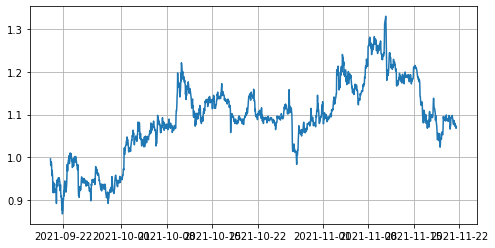

In [13]:
plt.figure(figsize=(8,4))
plt.plot(df['datetime'], df['close'])
plt.grid()

# Backtest

In [20]:
tb = 60
data = df['close']
rb = EnvRebalance(data, initial_capital=1000, fee=0,  min_diff=0.03, fixed_asset_value=500) 

========Backtesting Performance========
begin_portfolio_value: 1000.00
end_portfolio_value: 1064.08
buy: 11, sell: 19
cashflow: 29.842 = 2.984%
Len:1501, 1501.00 hrs. = 62.54 days


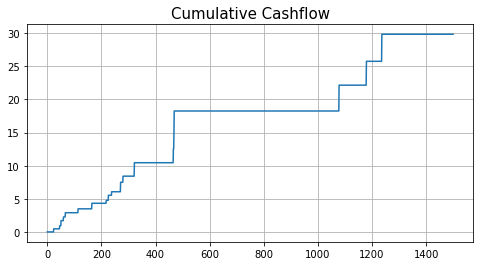

In [21]:
state = rb.reset()
cashflow = []
eqtc = []
i = 0

while True:
    
    next_state, reward, done, info = rb.step()
    cashflow.append(rb.cashflow)
    eqtc.append(rb.port_val())

    #print(f'{i} Price:{rb.stock_price:5f}, Cash:{rb.cash:.3f}, Asset:{rb.position:.3f}, Value:{rb.position*rb.stock_price:.3f}, cf:{rb.cashflow:.3f}')
    
    state = next_state
    i += 1
  
    if done:

        print(f'========Backtesting Performance========')
        print(f'begin_portfolio_value: {rb.initial_capital:.2f}')
        print(f'end_portfolio_value: {rb.port_val():.2f}')
        print(f'buy: {rb.n_buy}, sell: {rb.n_sell}')
        print(f'cashflow: {rb.cashflow:.3f} = {rb.cashflow/rb.initial_capital*100:.3f}%')
        print(f'Len:{rb.n_step}, {rb.n_step*tb/60:.2f} hrs. = {(rb.n_step*tb/60)/24:.2f} days')
        print("=======================================")

        break
    
plt.figure(figsize=(8,4))
plt.plot(np.array(cashflow))
plt.grid()         
plt.title('Cumulative Cashflow', fontsize=15);            

In [22]:
bt_data = df.iloc[1:].reset_index(drop=True).set_index(['datetime'])
bt_data['equity curve'] = eqtc

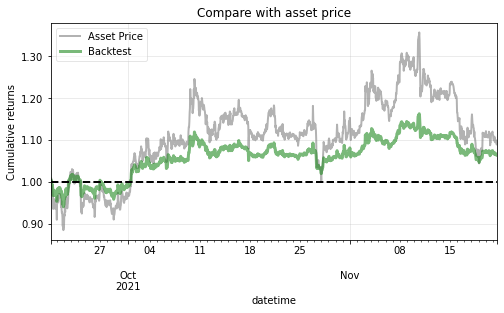

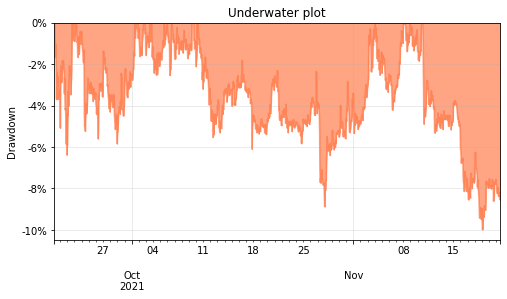

In [23]:
#PLot compare with benchmark
plt.figure(figsize=(8,4));
eqtc = bt_data['equity curve']
bt_data = bt_data.rename(columns = {'close': 'Asset Price'})

pf.plotting.plot_rolling_returns(eqtc.pct_change(), bt_data['Asset Price'].pct_change());
plt.grid(alpha=0.3)
plt.title('Compare with asset price');

plt.figure(figsize=(8,4));
pf.plot_drawdown_underwater(eqtc.pct_change());
plt.grid(alpha=0.3)

# Compare %diff rebalance

In [26]:
percent_diff = np.arange(0.08, 0.1, 0.01)

In [27]:
cashflow = [[] for i in percent_diff]
count = 0

for i in (percent_diff):
    rb = EnvRebalance(data, initial_capital=300, fee=0.02,  min_diff=i, fixed_asset_value=150) 

    state = rb.reset()
    
    while True:

        next_state, reward, done, info = rb.step()
        cashflow[count].append(rb.cashflow)

        state = next_state

        if done:
            break
            
    count += 1

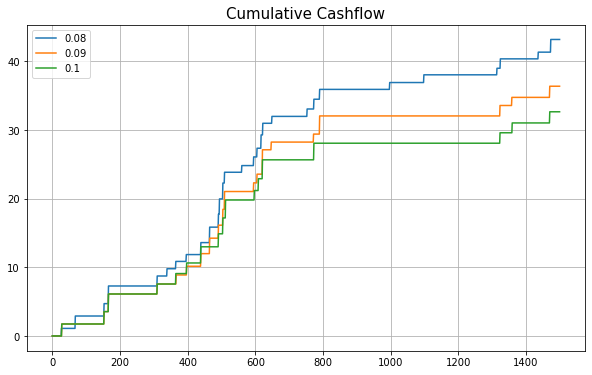

In [28]:
plt.figure(figsize=(10,6))
for i in range(len(percent_diff)):
    plt.plot(cashflow[i])
plt.legend([str(round(i, 3)) for i in percent_diff])
plt.grid()         
plt.title('Cumulative Cashflow', fontsize=15);

In [311]:
'''plt.figure(figsize=(10,6))
plt.plot(pd.DataFrame(equity_curve).pct_change().cumsum(), 'orange')
plt.plot(data.pct_change().cumsum(), 'green')
plt.legend(['Rebalance', 'XRP/USD'])
plt.grid()'''

"plt.figure(figsize=(10,6))\nplt.plot(pd.DataFrame(equity_curve).pct_change().cumsum(), 'orange')\nplt.plot(data.pct_change().cumsum(), 'green')\nplt.legend(['Rebalance', 'XRP/USD'])\nplt.grid()"